In [ ]:

!pip install git+https://github.com/facebookresearch/segment-anything-2.git
!pip install transformers opencv-python matplotlib requests --quiet

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-541wy17d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-541wy17d
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2025-10-03 17:03:58--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.74, 18.154.144.13, 18.154.144.87, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   149MB/s    in 47

In [ ]:
img_path = "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/zidane.jpg"
try:
    img = Image.open(requests.get(img_path, stream=True).raw).convert("RGB")
except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

In [ ]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

text_prompt = "football player"
inputs = processor(text=[text_prompt], images=[img], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
mask = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()

In [ ]:

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to(device)
predictor = SamPredictor(sam)

np_img = np.array(img)
predictor.set_image(np_img)

seed_points = np.argwhere(mask > 0.25)

if len(seed_points) > 0:
    print("Found seed points! Refining with SAM...")
    seed = seed_points[len(seed_points)//2]
    masks, scores, logits = predictor.predict(
        point_coords=np.array([[seed[1], seed[0]]]),
        point_labels=np.array([1])
    )
else:
    print("Could not find any confident seed points from the initial mask.")
    print(f"The maximum value in the mask was only: {mask.max()}")
    masks = [np.zeros(np_img.shape[:2], dtype=bool)] # Create an empty mask

Could not find any confident seed points from the initial mask.
The maximum value in the mask was only: 0.013076155446469784


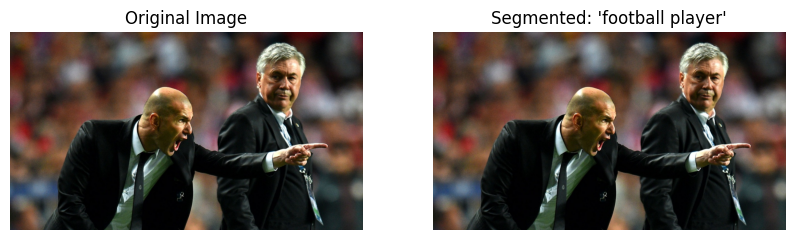

In [ ]:
mask_final = masks[0]
overlay = np_img.copy()
# Create a red color overlay where the mask is true
overlay[mask_final] = np.array([255, 0, 0]) * 0.6 + overlay[mask_final] * 0.4


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(np_img)
plt.axis("off")


plt.subplot(1, 2, 2)
plt.title(f"Segmented: '{text_prompt}'")
plt.imshow(overlay)
plt.axis("off")

plt.show()